# Case 3. Medical text categorization   
Joona Klemetti  
10.3.2018   
Cognitive Systems for Health Technology Applications    
Helsinki Metropolia University of Applied Science

#  1. Objectives   
The aim of this case is to use recurrent and convolutional neural networks to create a classifier for a collection of medical abstracts extracted from MEDLINE, the online medical information database.


# 2. Required libraries   
At first it is necessary to import all libraries. In this assignment is used os module to downloading and listing data and labels, time library to comput the time, numpy to scientific computing and creating multidimensional arrays, Keras to preproces data, define labels, building and training the model, matplotlib to ploting history and sklearn to calculate metrics.

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical

from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

Using TensorFlow backend.


# 3. Data description and preprocessing   
The data used in this case is the Cardiovascular diseases abstract database from MEDLINE. The data is already splited into training and test sets and abstracts are in sub-folders according to their categories. The data is downloaded from http://disi.unitn.it/moschitti/corpora.htm. Visit there if you want more information of used abstracts. For more infrormation of labels please visit http://disi.unitn.it/moschitti/corpora/First-Level-Categories-of-Cardiovascular-Disease.txt   
<br>
At first medical abstracts and labels are downloaded. After that abstracts is collected into lsit of strings. Labels is also collected to the labels list. Next the data is tokenized, maxium length of text and number of words is defined. Data is also shaped into right shape and shuffled. Shuffeling is important because otherwise there will be problems when spliting data into training and validation set. Without shuffling validation set consists only abstracts from last two categories. 


In [3]:
ohsumed_dir = 'ohsumed-first-20000-docs'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

t1 = time.time()

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)
t2 = time.time()
print('Time elapsed {:.0f} seconds.'.format((t2-t1)))

Time elapsed 22 seconds.


In [4]:
maxlen = 250
max_words = 20000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


In [5]:
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 250)
Shape of labels tensor: (10433, 23)


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

# 3. Building the model   
The recurrent neural network is build by using keras sequential model. The first layer, Embedding layer, is turned positive integers to dense vectors. After Embedding layer there is two LSTM recurrent layers with dropout and recurrent_dropout arguments to avoid overfitting. LSTM is abbreviation for long short-term memory and it is founded in 1997. At least there is dense layer with softmax activation to split data to the 23 categories.

In [7]:
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(LSTM(100, return_sequences = True, dropout = 0.4, recurrent_dropout = 0.2))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.4))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 32)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 23)                2323      
Total params: 775,923
Trainable params: 775,923
Non-trainable params: 0
_________________________________________________________________


# 5. Training and Validation
After model is build is time to train and validate the network. Training is executed with .fit() method. Validation split is defined by validation_split argument. 

In [8]:
t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 20,
                   batch_size = 34,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/20
8346/8346 [==============================] - 194s 23ms/step - loss: 2.8224 - acc: 0.1691 - val_loss: 2.7976 - val_acc: 0.1624
Epoch 2/20
8346/8346 [==============================] - 186s 22ms/step - loss: 2.7106 - acc: 0.1913 - val_loss: 2.6602 - val_acc: 0.2142
Epoch 3/20
8346/8346 [==============================] - 193s 23ms/step - loss: 2.6165 - acc: 0.2153 - val_loss: 2.6487 - val_acc: 0.2113
Epoch 4/20
8346/8346 [==============================] - 187s 22ms/step - loss: 2.5576 - acc: 0.2360 - val_loss: 2.6529 - val_acc: 0.2209
Epoch 5/20
8346/8346 [==============================] - 192s 23ms/step - loss: 2.5092 - acc: 0.2574 - val_loss: 2.6790 - val_acc: 0.2520
Epoch 6/20
8346/8346 [==============================] - 189s 23ms/step - loss: 2.4818 - acc: 0.2644 - val_loss: 2.6024 - val_acc: 0.2401
Epoch 7/20
8346/8346 [==============================] - 194s 23ms/step - loss: 2.3878 - acc: 0.2872 - val_loss: 2.5972 - val_acc: 

# 6. Evaluation 
Model is tested with testing set. Evaluate function computes testing sets loss function and accuracity.

In [9]:
# Download and preproces test data

test_dir = os.path.join(ohsumed_dir, 'test')

test_labels = []
test_texts = []

for label_type in L:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        i = L.index(label_type)
        test_labels.append(i)
        
test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = np.asarray(test_labels)
y_test = to_categorical(test_labels)

#Evaluate model with test data
model.evaluate(x_test, y_test)

12733/12733 [==============================] - 66s 5ms/step


[2.5768937821999787, 0.26930024346655185]

# 7. Results and Discussion
There is noticed overfitting in the model and despite to dropout arguments it stil bother the network. Overfitting could be seen from lower testing accuracy and higher loss. It is interesting that testing accuracy and loss are much better than validation results. Like you could see from the graphs overfitting started about after 6th epoch. 

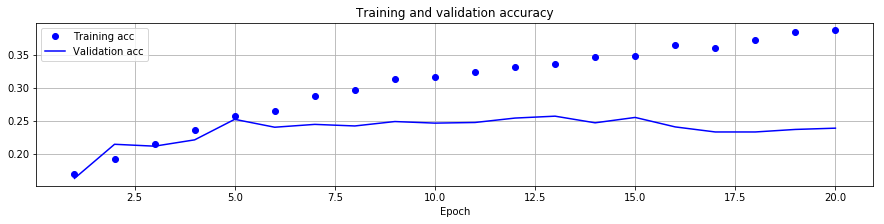

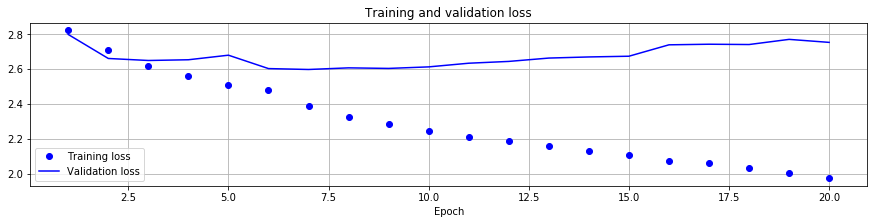

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 8. Metrics results   
Metrics are calulate by sklearn library. There are classification report, confusion matrix and possibility to check predictions by text.

In [11]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.35      0.33      0.34       423
          1       0.00      0.00      0.00       158
          2       0.00      0.00      0.00        65
          3       0.48      0.73      0.58      1163
          4       0.40      0.16      0.23       283
          5       0.45      0.30      0.36       588
          6       0.00      0.00      0.00       100
          7       0.25      0.18      0.21       473
          8       0.00      0.00      0.00       125
          9       0.42      0.11      0.18       621
         10       0.29      0.14      0.19       162
         11       0.29      0.21      0.24       491
         12       0.35      0.12      0.18       281
         13       0.56      0.80      0.66      1249
         14       0.20      0.07      0.10       215
         15       0.00      0.00      0.00       200
         16       0.33      0.29      0.31       295
         17       0.51      0.44      0.47   

C:\Users\Joona\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
# Confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 120))

[[ 141    0    0   13    3   11    0   23    0    1    7    5    5   20    2    0    8    5    0   80   12    0   87]
 [  15    0    0   13    0    0    0    5    0    0    0    1    6    2    0    0    3    0    0   99    0    0   14]
 [  22    0    0    1    0    1    0    1    0    0    4    2    0    1    0    0    3    0    0   10    1    0   19]
 [   2    0    0  851    1   48    0    9    0    1    1   42    7   10    5    0    9    1    3   31    2    0  140]
 [  13    0    0   15   45    3    0    8    0    7    7    3    0    9    0    0    5   14    4    8   58    0   84]
 [   9    0    0   72    1  178    0    4    0    2    0   11    0   13    1    0    0    3    0   24    9    0  261]
 [   3    0    0   37    4    0    0    5    0    0    2    4    0    0    1    0    6    5    4    5    3    0   21]
 [  16    0    0  120    3    1    0   86    0    1    1   24    6   30   11    0   11    0    0   54    1    0  108]
 [   3    0    0   46    1    3    0   17    0    0    0

In [19]:
predict_text=503
print(texts[indices[predict_text]])

National General Practice Study of Epilepsy: recurrence after a first seizure 
 In the National General Practice Study of Epilepsy 564 patients classified as having definite seizures have been followed up for 2-4 years.
 67% (95% confidence interval 63-71%) had a recurrence within 12 months of the first seizure, and 78% (74-81%) had a recurrence within 36 months.
 Seizures associated with a neurological deficit presumed present at birth had a high rate of recurrence (100% by 12 months), whereas seizures that occurred within 3 months of an acute insult to the brain, such as head injury or stroke, or in the context of an acute precipitant such as alcohol, carried a much lower risk of recurrence (40% [29-51%] by 12 months).
 Other factors affecting the risk of recurrence were age-the highest risk being for patients under the age of 16 (83% [77-89%] by 36 months) or over the age of 59 (83% [76-90%] by 36 months-and type of first seizure-the risk of recurrence being much higher for patients

True class:  22
Predicted class: 22
Predictions per class:
[ 0.01  0.    0.    0.03  0.01  0.06  0.    0.01  0.    0.19  0.    0.03
  0.01  0.14  0.01  0.03  0.01  0.01  0.    0.    0.02  0.    0.44]


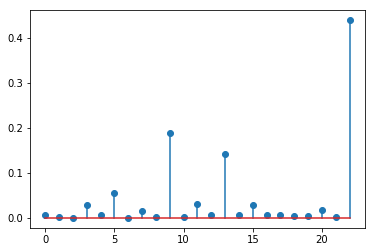

In [20]:
print('True class: ', labels[predict_text])
print('Predicted class:', y_pred[predict_text])
print('Predictions per class:')
print(np.array2string(predictions[predict_text], precision = 2))

plt.stem(predictions[predict_text])
plt.show()

# 9. Conclusions   
The case 3. was good introduction to NLP and recurrent neural networks.  I think the difficulty level was just right. The objectives were achieved such the neural network works. There could be little more time to do this assignment. With more time some unsolved problems could be fixed.   
<br>
The validation accuracy and loss were worse than test accuracy and loss. That is interesting and needs more time to investigate it more. With quick research it can not be found any information about phenomenon.   
<br>
It seems that 20 000 abstracts is not enough to build good model for medical text classifier. Training accuracy never rise over 0.5 with LSTM layers. Lightly over 0.25 test accuracy is not good for medical classifier. However 0.25 is much better than random guess.   
<br>

